# Machine Learning in Python - Group Project 1

**Due Friday, March 10th by 16.00 pm.**

Group 15: William Jones, Elliot Leishman, Tristan Pang and Aidan Garrity

## General Setup

In [409]:
# Add any additional libraries or submodules below

# Data libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules that are necessary
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

In [410]:
# Load data
data = pd.read_csv("the_office.csv")

## 1. Introduction

IMBd ratings give a valuable indicator on how popular episodes of television shows are with viewers. NBC Universal would like to understand what makes certain episodes of The Office more popular than others, so they can produce a special reunion episode with as high an IMBd rating as possible. 

This report uses data on The Office to build and validate a predictive model that captures the underlying relationship between episode features and IMBd rating, and advises on what NBC Universal should include in a reunion episode to maximise audience popularity. 

We acheive this by first performing data exploration to select or remove certain features, and then we investigate the effectiveness of different regression models using a training-test split of our data. 

<span style="color:red">
We find that a LASSO model gives the best $R^2$ score, allowing us to conclude that [FINISH THIS ONCE WE HAVE CONCLUSION]
</span>

The primary dataset we are using is displayed below. We have a dataset of every episode of the office, critically containing an IMBd rating for each episode amongst other features which are either categorical (writers, characters etc.) or numeric (number of lines, number of directions etc.). We use one-hot encoding to encode the categroical variables. 

We also introduce some additional data [1], from which we develop some useful features. The dataset is the script of the entire show - each row of the dataset contains an episode, series and scene number, a line said in the show ('line_text'), the character ('speaker') who said the line, and whether the line was in a deleted scene or not. From this we can find the number of scenes ('n_scenes') said in each episode, which gives an idea of optimal episode pacing, and the number of lines each main character says in each episode, effectively ranking a character's importance in an episode. 

In [411]:
# load additional data [1]
data_lines = pd.read_csv("the-office-lines.csv")

# display both datasets
display(data)
display(data_lines)

### Initial data manipulation ###

# remove deleted scenes
data_lines = data_lines[~data_lines.deleted]

# get number of scenes per episode
n_scenes = data_lines.groupby(['season', 'episode'])['scene'].max()

# add number of scenes per episode to our dataframe
data['n_scenes'] = np.array(n_scenes)

# add count column to dataframe
data_lines['n_lines'] = 1

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars,n_scenes
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,39
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,46
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,39
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,56
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9,19,Stairmageddon,Matt Sohn,Dan Sterling,8.0,1484,2013-04-11,273,59,2965,24,Andy;Angela;Creed;Dwight;Erin;Jim;Kevin;Meredi...,49
182,9,20,Paper Airplane,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,2013-04-25,234,48,2564,27,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...,46
183,9,21,Livin' the Dream,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,2013-05-02,382,33,4333,20,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...,53
184,9,22,A.A.R.M,David Rogers,Brent Forrester,9.3,2860,2013-05-09,501,54,4965,30,Andy;Angela;Creed;Darryl;Dwight;Erin;Jim;Kevin...,70


,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
...,...,...,...,...,...,...,...
59904,59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False
59905,59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False
59906,59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False
59907,59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,False


## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 A brief overview of the data

In [412]:
# Investigate the datatypes of the dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
 13  n_scenes      186 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 20.5+ KB


None

The first output shows that our dataset contains 186 rows (observations) with 13 columns (features). We have already identified 'imdb_rating' as our output leaving us with 12 features. 

The non-null count column tells us we have no null values in our dataset, therefore no cleaning regarding null values is needed. 

Seven of our columns are of datatype 'int64' - checking the corresponding columm names and storing these values as an integer seems sensible and no manipultion of these data features is necessary. There is one feature of datatype 'float64', namely 'imdb_rating', this is an appropriate datatype because IMDB report there rating with an accuracy of 1 decimal place. Finally, we have five features of datatype 'object', these features will be given special consideration in this section.

In [413]:
# Exploration of Numeric Features - Should we have already dropped season, episode etc.? Or add Box plots in here?

# Print summary statistics for numeric features - rounded to 2 decimal places.
display(data.describe().round(2))

,season,episode,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,n_scenes
count,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00,186.00
mean,5.46,12.48,8.25,2129.54,296.40,50.15,3053.51,20.69,48.52
std,2.40,7.23,0.54,790.79,82.00,23.94,799.27,5.09,16.07
min,1.00,1.00,6.70,1393.00,131.00,11.00,1098.00,12.00,21.00
25%,3.00,6.00,7.90,1628.50,255.25,34.00,2670.25,17.00,38.00
50%,6.00,12.00,8.20,1954.00,281.00,46.00,2872.50,20.00,46.00
75%,7.75,18.00,8.60,2385.00,314.50,60.00,3141.00,23.00,53.00
max,9.00,28.00,9.70,7934.00,625.00,166.00,6076.00,54.00,116.00


Is this above really Necessary in Final report?

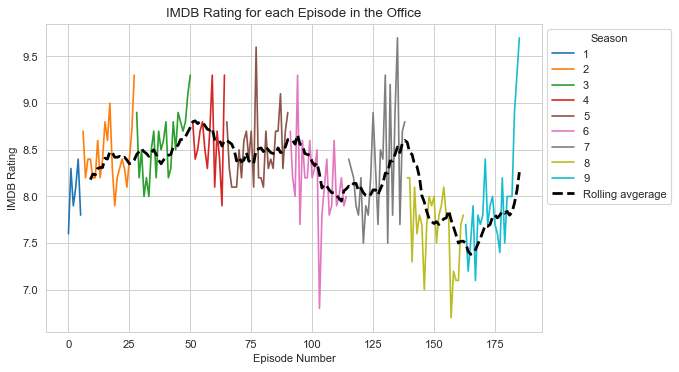

In [414]:
data_indexed = data.reset_index() 

cmap = plt.get_cmap("tab10") # define colours
sns.set_style(style= 'whitegrid')

# Plot ratings of each season
ax = sns.lineplot(data = data_indexed, x = 'index', y = 'imdb_rating', hue = 'season', palette= cmap, legend = 'full')

# Calculate and plot rolling average
data_indexed[ '10ep_rolling_avg' ] = data_indexed.imdb_rating.rolling(10).mean()
sns.lineplot( x = 'index', y = '10ep_rolling_avg', data = data_indexed, label = 'Rolling avgerage', linestyle='dashed', color = 'black', linewidth = 2.5)

# Axis setup
ax.legend(title = 'Season')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('IMDB Rating for each Episode in the Office')
plt.xlabel('Episode Number')
plt.ylabel('IMDB Rating')
plt.show()



Although this figure does not provide the most in-depth insights into each episode, it does allow us an overview of the general trend in IMDB rating as the show progressed as well as hightlighting potential outliers in the dataset. 

In regard to overall trend, consulting the rolling average of the previous 10 episodes, we can clearly see the show experienced a slow and steady increase in ratings throughout the first three seasons. This is most likely due to the show finding its feet and developing its own identity. The shows ratings appear relatively stable throughout the next 4 seasons except a small dip towards the end of season 6 and continuing into the beginning of season 7. It is season 8 where the show experienced its biggest decline in ratings, this could be due to many factors, such as the show losing creativity in writing/ directing or a shake-up in the cast members. Interestingly, the shows ratings increased into the final season, and continued on an upward trajectory thorughout the season, perhaps due to nostalgia. Other trends we can see from the figure is importance of the season finale. Note that in seasons 2,3,4 and 9, the season finale appears to be the highest rated episode in the season. This could be due to the payoff of several theme and character arcs from the season.

An interesting outlier is the lowest rated episode in season 6. Although this is not the overall lowest rated episode, it is clearly the episode which deviates (negatively) from it's season average the most. Another outlier is the final episode of the entire series, which is the (joint) highest rated episode of the series. This is likely due to it being the finale, rounding off the show. 

### 2.2 Data Cleaning

We choose not to remove the above outlier episodes as they may give some indication into what features gives a particularly good or bad episode - for example, the character 'Michael' returns in the final episode of the series, which may have been a contributing factor the spike in rating. 

At this point it is important to remember the brief of our task 'to advise what NBC Universal should do to produce the highest rated reunion episode possible'. We will not include the following features:
- 'season' and 'episode'. A special reunion episode will not fit into the standard seasons format.
- 'air_date'. The reunion episode will air significantly after the official finale in 2013. 
- 'episode_name'. These are unique strings and will be dictated by episode content. 
- 'total_votes'. This may be a good indicator of how well an episode is doing, but it is not a factor we can control. 

In [415]:
# Drop irrelevant columns
data = data.drop(columns=['season', 'episode', 'episode_name', 'air_date', 'total_votes'])

### 2.3 Correlation 

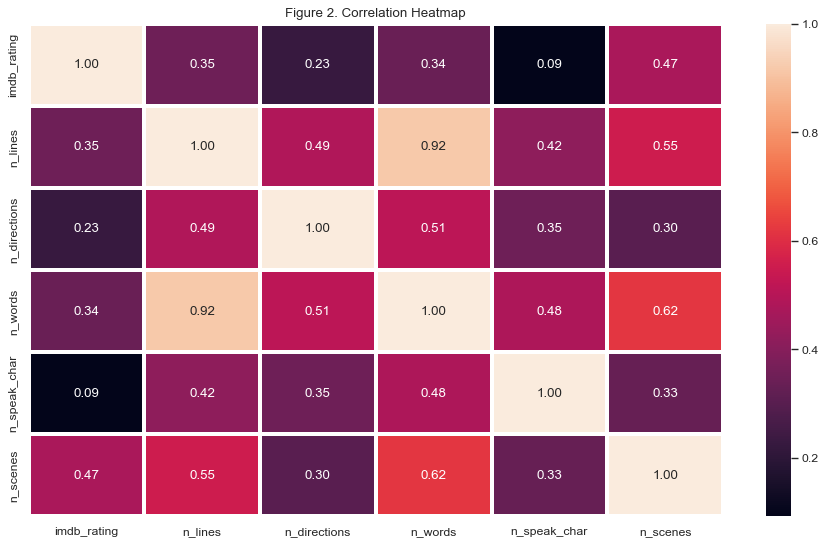

In [416]:
sns.set(rc={'figure.figsize': (14, 8)})

# Correlation heatmap 
sns.heatmap(data.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()

# Correlation pairplot
#sns.pairplot(data, hue = 'writer')

From Figuere 2 we can see that firstly all the variable are positively correlated to all other variables. The strongest correlation is between 'n_words' and 'n_lines' which not only suggests that the number of words per line is fairly constant throughout the series but only one of these features may be required in our model. The features most highly correlated with 'imbd_rating' are 'n_lines' and 'n_words'.

Figure 3 shows us that...

### 2.4 Diagnostic Plots

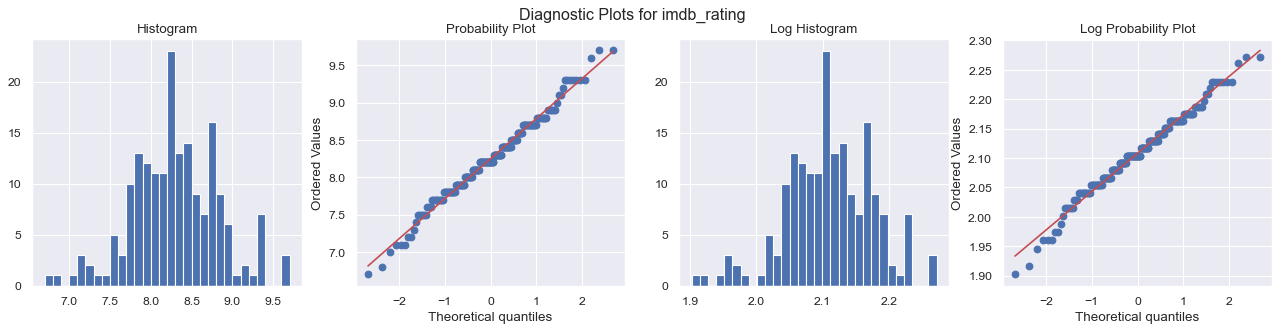

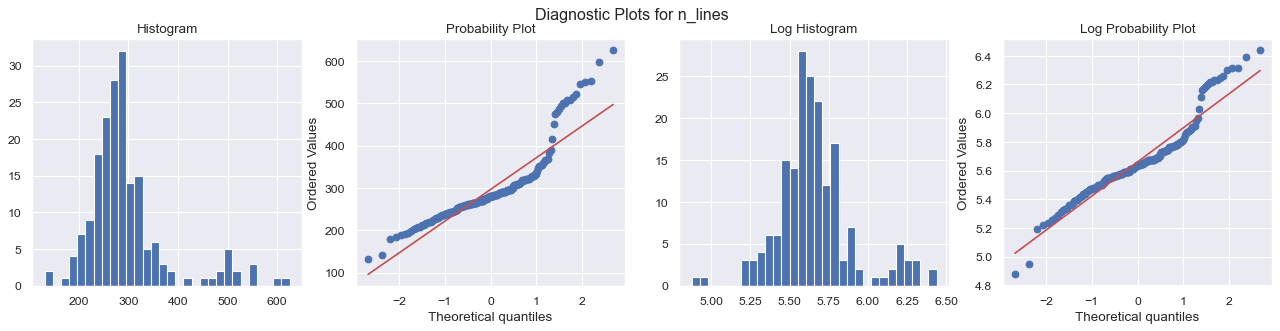

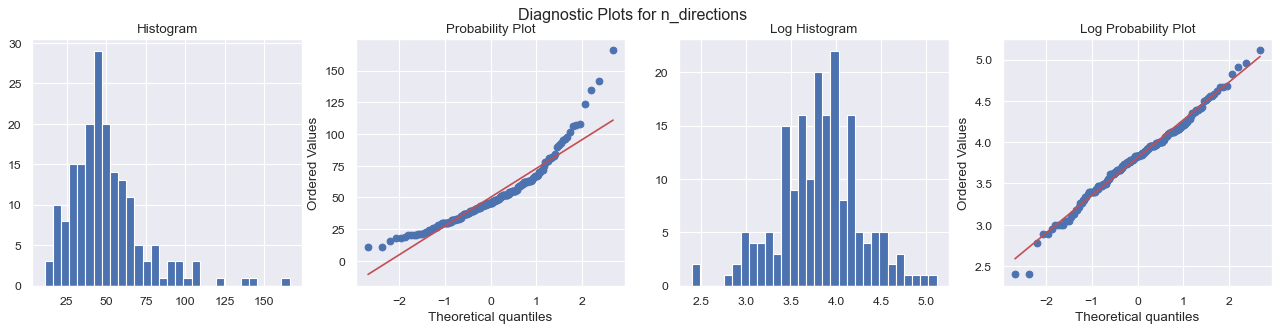

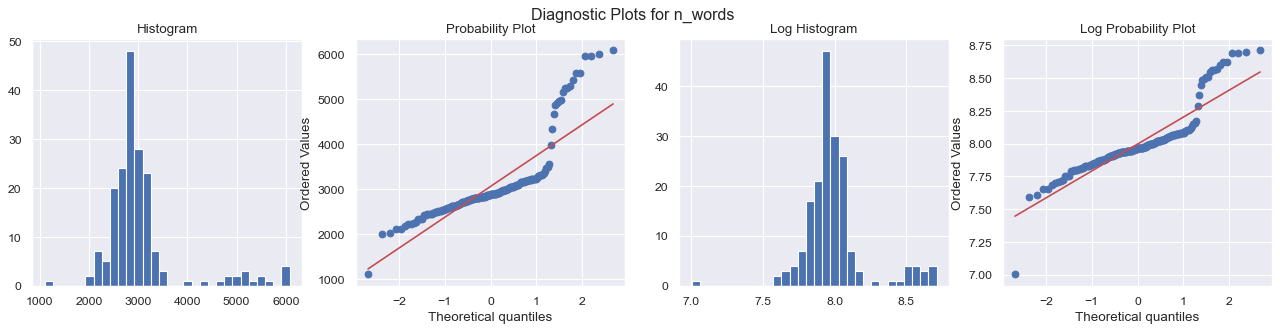

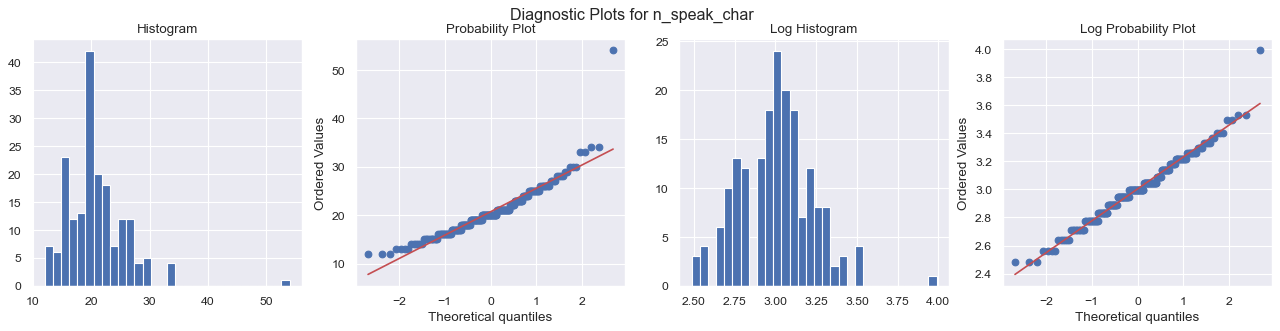

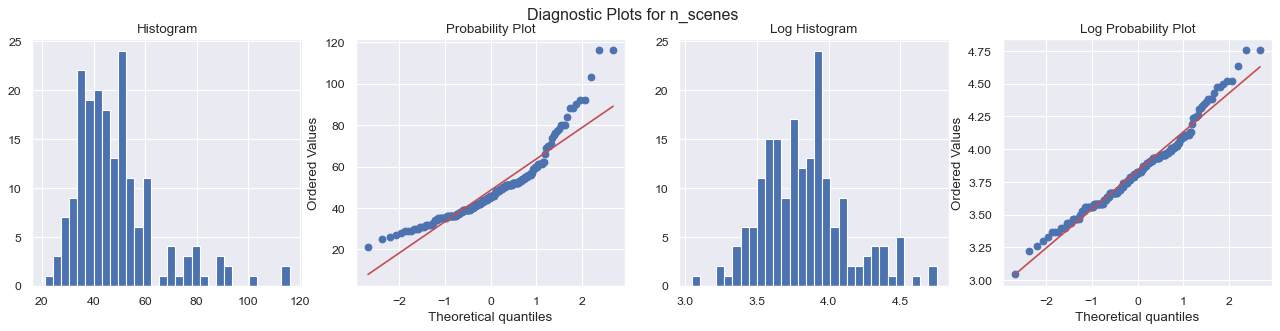

In [417]:
def diagnostic_plots(df, variable): 
    """
        Distributions of variable in dataframe - from Python Feature Engineering Cookbook.
        Outputs histogram, probability plot, log histogram, and log probability plot of variable distribution. 
    """

    plt.figure(figsize=(20,4)) 

    # Histogram
    plt.subplot(1, 4, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")

    # Probability Plot
    plt.subplot(1, 4, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 

    # Log Histogram
    plt.subplot(1, 4, 3) 
    np.log(data[variable_name]).hist(bins=30)
    plt.title("Log Histogram")

    # Log Probability Plot
    plt.subplot(1, 4, 4)
    stats.probplot(np.log(data[variable_name]), dist="norm", plot=plt) 
    plt.title("Log Probability Plot")

    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

# run the diagnostic plots for all the features we are interested in 
for variable_name in data.select_dtypes(exclude = 'object'): # excludes columns with data type object, i.e. only investigate numeric values
    diagnostic_plots(data, variable_name)

The histogram for 'imdb_ratin' suggest that the ratings are normally distributed, this corroberated by the QQ-plot. For 'n_lines' we can see that the histogram shows the distribution is heavily skewed to the left, this appears to sorted by taking the logarithm. Note, the histogram and QQ-plot of 'log(n_lines)' show strong normality. Similarly, 'n_directions', 'n_words' and 'n_speak_char' are all closer to normally distributed when logged. Therefore, we would expect to use logged values in our analysis...

In [418]:
# log data to make it normal
data['n_scenes'] = np.log(data['n_scenes'])
data['n_directions'] = np.log(data['n_directions'])

### 2.5 Feature Investigation: Characters

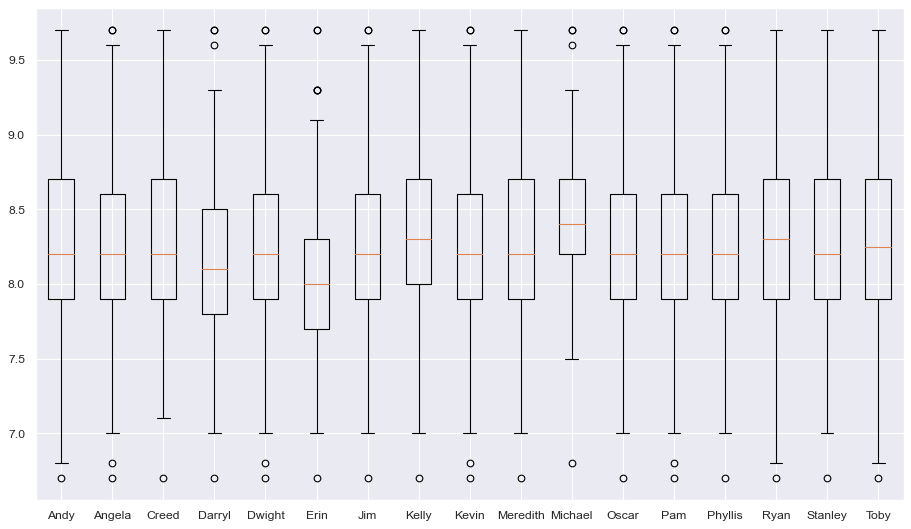

In [419]:
# Investigating effect of characters on imdb rating
chars = data['main_chars']
chars = chars.str.split(';', expand = False)
chars = pd.get_dummies(chars.apply(pd.Series).stack()).sum(level=0)

chars2 = pd.merge(data['imdb_rating'], chars, left_index=True, right_index=True)

plotting=[]
for character in chars:
    condition = character + '==1'
    plotting.append(chars2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,18), chars.columns)
plt.show()

In [420]:
chars2.sort_values(by = ['imdb_rating'])

,imdb_rating,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
157,6.7,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1
103,6.8,1,1,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1
146,7.0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0
160,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
167,7.1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,9.3,1,1,1,1,1,1,1,0,1,1,0,1,1,1,0,1,0
59,9.3,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0
77,9.6,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0
135,9.7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


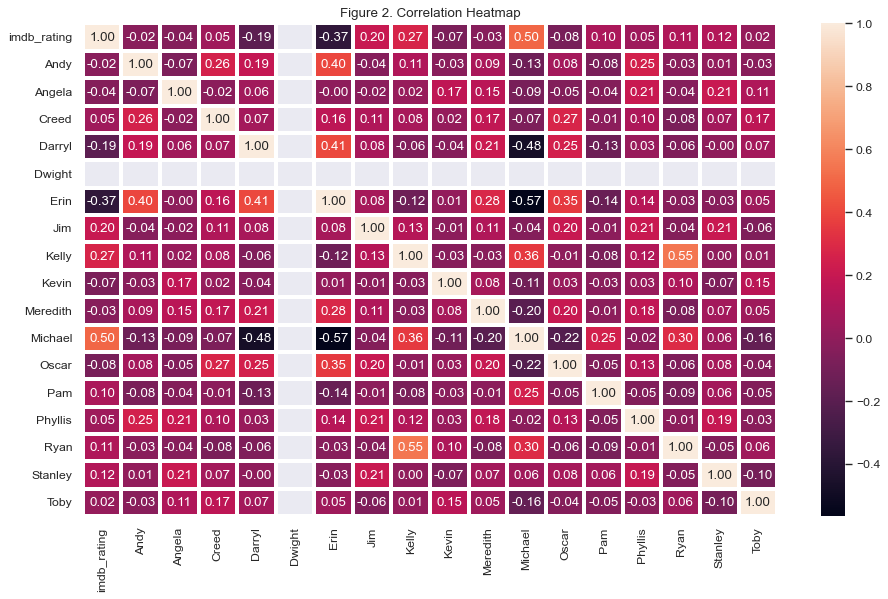

Andy        143
Angela      171
Creed       131
Darryl      105
Dwight      186
Erin         98
Jim         185
Kelly       142
Kevin       180
Meredith    131
Michael     137
Oscar       164
Pam         182
Phyllis     165
Ryan        139
Stanley     165
Toby        108
dtype: int64

In [421]:
# Correlation
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(chars2.corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Figure 2. Correlation Heatmap")
plt.show()
chars.sum()

### 2.6 Feature Investigation: Writers

,AaronShure,BJNovak,BrentForrester,CarrieKemper,CharlieGrandy,DanielChun,GeneStupnitsky,GregDaniels,HalstedSullivan,JenniferCelotta,JustinSpitzer,LeeEisenberg,MichaelSchur,MindyKaling,Other,OwenEllickson,PaulLieberstein,RobertPadnick,WarrenLieberstein
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
182,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
183,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
184,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


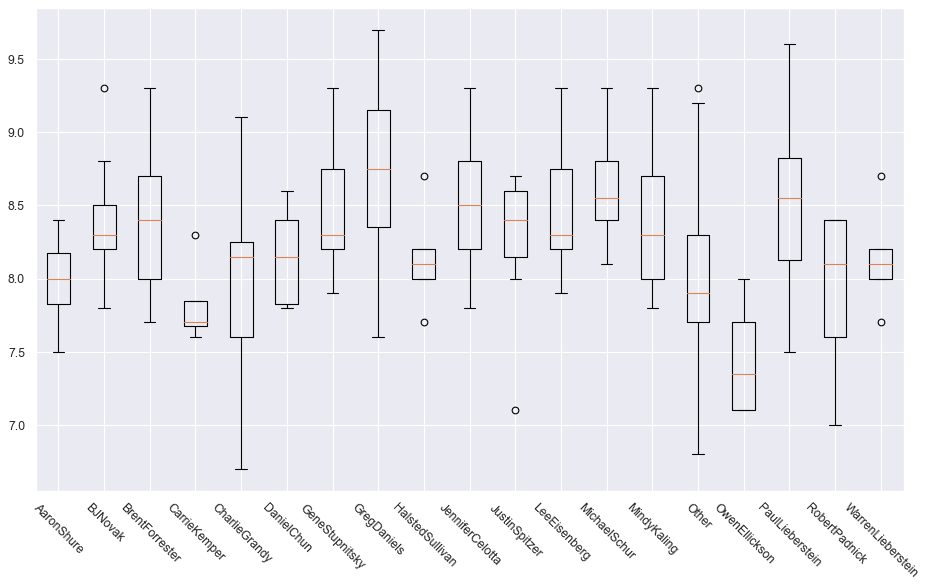

In [422]:
def split_names(column, minimum = -np.inf, df=data):
    '''
    Split names in a specific column by `;` and ignore other puntuation. Drop people with less than or equal minimum episodes
    '''
    # Retrieve data 
    data_column = (df[column]).copy()
    
    # Remove punctuation
    for punc in [' ', '.', '-']:
        data_column = data_column.str.replace(punc,'')
    
    # Split semicolon
    data_column = data_column.str.split(';',expand=False)
    
    allpeople = [item for sublist in data_column.to_list() for item in sublist].copy() # all possible people
    peopleepisodes = {x: allpeople.count(x) for x in allpeople}.copy() # number of episodes corresponding to a person 
    
    new_data_column = [] # new data without people <= minimum
    for episode in data_column: # iterate over all data
        new_episode = []
        for contributor in episode: # iterate over episodes
            if peopleepisodes[contributor] > minimum: # if person has enough episodes, add to new data
                new_episode.append(contributor)
        if new_episode == []: # if no one has over minimum, then set label as other
            new_episode.append('Other') 
        new_data_column.append(new_episode)
    new_data_column = pd.Series(new_data_column)
    data_column = pd.get_dummies(new_data_column.apply(pd.Series).stack()).sum(level=0)

    return data_column.copy()

writers = split_names('writer', minimum=3)
writers2 = pd.merge(data['imdb_rating'], writers, left_index=True, right_index=True)
display(writers)
plotting=[]
for writer in writers:
    condition = writer + '==1'
    plotting.append(writers2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,len(writers.columns)+1), writers.columns)
plt.xticks(rotation = 315)
plt.show()

### 2.7 Feature Investigation: Directors

,BJNovak,BrentForrester,CharlesMcDougall,DavidRogers,GregDaniels,HaroldRamis,JeffreyBlitz,KenKwapis,KenWhittingham,MattSohn,Other,PaulFeig,PaulLieberstein,RandallEinhorn,TuckerGates
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
182,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
183,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
184,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


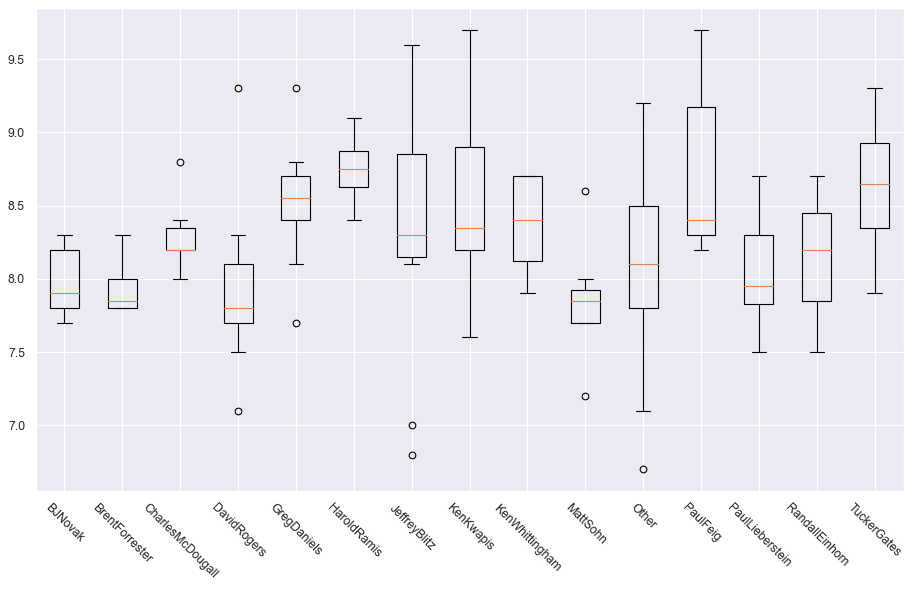

In [423]:
directors = split_names('director', minimum=3)
display(directors)
directors2 = pd.merge(data['imdb_rating'], directors, left_index=True, right_index=True)

plotting=[]
for director in directors:
    condition = director + '==1'
    plotting.append(directors2.query(condition)['imdb_rating'])
plt.boxplot(plotting)
plt.xticks(np.arange(1,len(directors.columns)+1), directors.columns)
plt.xticks(rotation = 315)
plt.show()

### 2.8 Feature Investigation: Lines said by Characters

In [424]:
reindex_df = pd.DataFrame(data_lines.groupby(['season', 'episode']).sum()).reset_index()

#reindex_df.query(f'season==1 and episode==1').index[0]
data_lines['total_episode']=0
for total_episode in reindex_df.index:
    s, e = reindex_df[['season','episode']].loc()[total_episode]
    index = [(data_lines['season']==s) & (data_lines['episode']==e)]
    data_lines['total_episode']=data_lines['total_episode']+(np.array(index)*total_episode)[0]

display(data_lines)

,id,season,episode,scene,line_text,speaker,deleted,n_lines,total_episode
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False,1,0
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,1,0
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False,1,0
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,1,0
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,1,0
...,...,...,...,...,...,...,...,...,...
59904,59905,9,23,112,It all seems so very arbitrary. I applied for ...,Creed,False,1,185
59905,59906,9,23,113,I just feel lucky that I got a chance to share...,Meredith,False,1,185
59906,59907,9,23,114,I���m happy that this was all filmed so I can ...,Phyllis,False,1,185
59907,59908,9,23,115,I sold paper at this company for 12 years. My ...,Jim,False,1,185


In [425]:
main_chars = data['main_chars']
main_chars = main_chars.str.split(';')
main_chars = list(main_chars.apply(pd.Series).stack().unique())

n_lines_character = data_lines.groupby(['total_episode', 'speaker'])['n_lines'].sum()
n_lines_character = n_lines_character.reset_index()
n_lines_character = n_lines_character[n_lines_character['speaker'].isin(main_chars)]
n_lines_character = n_lines_character.reset_index()

n_lines_character = n_lines_character.pivot(index='total_episode',columns='speaker',values='n_lines').fillna(0)

display(n_lines_character)

speaker,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,Michael,Oscar,Pam,Phyllis,Ryan,Stanley,Toby
total_episode,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,29.0,0.0,36.0,0.0,1.0,0.0,81.0,3.0,41.0,2.0,8.0,5.0,0.0
1,0.0,4.0,0.0,0.0,19.0,0.0,27.0,2.0,8.0,0.0,81.0,13.0,16.0,0.0,4.0,5.0,2.0
2,0.0,5.0,0.0,0.0,62.0,0.0,42.0,0.0,6.0,3.0,56.0,9.0,32.0,0.0,1.0,6.0,0.0
3,0.0,7.0,0.0,0.0,58.0,0.0,49.0,0.0,3.0,10.0,79.0,14.0,22.0,5.0,4.0,2.0,4.0
4,0.0,3.0,0.0,15.0,26.0,0.0,22.0,0.0,1.0,0.0,106.0,2.0,14.0,4.0,8.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,31.0,4.0,2.0,0.0,61.0,10.0,15.0,0.0,5.0,2.0,0.0,7.0,9.0,5.0,0.0,21.0,15.0
182,39.0,16.0,1.0,10.0,21.0,16.0,17.0,0.0,10.0,0.0,0.0,2.0,22.0,0.0,0.0,2.0,7.0
183,68.0,30.0,2.0,11.0,54.0,9.0,63.0,0.0,13.0,1.0,0.0,19.0,30.0,4.0,0.0,4.0,7.0


## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

<span style="color:red">
I believe the plan is to use LASSO regression as it will perform feature selection which will improve interpretability.

'Ridge regression is useful when there is a concern about multicollinearity, and Lasso regression is useful when there are many predictors and some are suspected to be irrelevant or have little effect on the outcome.'

Should we use Cross-Validation to reduce variability in model fit and hence validation error?

A proposal for a general section plan:

    - Start with a simple general linear model with all the shit in it. We can use this as a baseline to show we are justified in making a more complicated model.
    - Make a LASSO model to get rid of un-necessary features
    - Maybe look into nonlinear or polynomial regression?

Other General things:

    - Should we consider named character in the main model, or should we instead, predict best number of characters and then try to find which characters they should be?
    - Should probably use the annoying SKlearn pipelines 
    - Comment code @Tristan Pang



Finally dont forget to 'regress the regression',

Your captian.

</span>

Import the get_coefs and model_fit functions from Workshop 5. This will allow us to evaluate our model fit and stuff.

In [426]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [427]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

In [428]:
# Splitting into test and train data
from sklearn.model_selection import train_test_split
people = n_lines_character.join(writers)
people = people.join(directors.add_suffix('_D'))
display(people)

X = data.drop('imdb_rating', axis = 1) # Set of features
X_ = pd.merge(X, people, left_index=True, right_index=True)
X_ = X_.fillna(0) # nan shenanigans

y = data['imdb_rating']

X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.10)
#X_test.head()

,Andy,Angela,Creed,Darryl,Dwight,Erin,Jim,Kelly,Kevin,Meredith,...,HaroldRamis_D,JeffreyBlitz_D,KenKwapis_D,KenWhittingham_D,MattSohn_D,Other_D,PaulFeig_D,PaulLieberstein_D,RandallEinhorn_D,TuckerGates_D
total_episode,,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,29.0,0.0,36.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,4.0,0.0,0.0,19.0,0.0,27.0,2.0,8.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,5.0,0.0,0.0,62.0,0.0,42.0,0.0,6.0,3.0,...,0,0,0,1,0,0,0,0,0,0
3,0.0,7.0,0.0,0.0,58.0,0.0,49.0,0.0,3.0,10.0,...,0,0,0,0,0,1,0,0,0,0
4,0.0,3.0,0.0,15.0,26.0,0.0,22.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,31.0,4.0,2.0,0.0,61.0,10.0,15.0,0.0,5.0,2.0,...,0,0,0,0,1,0,0,0,0,0
182,39.0,16.0,1.0,10.0,21.0,16.0,17.0,0.0,10.0,0.0,...,0,0,0,0,0,1,0,0,0,0
183,68.0,30.0,2.0,11.0,54.0,9.0,63.0,0.0,13.0,1.0,...,0,1,0,0,0,0,0,0,0,0


In [429]:
# Linear regression - move to top?
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define headers to regress on
head0 = [ 'n_lines', 'n_directions', 'n_words', 'n_speak_char']

head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
print(test_model.intercept_)
coeffs = pd.DataFrame(test_model.coef_, head, columns=['Coefficients'])
coeffs

Train $R^2$ 0.5487113368885681
Test $R^2$ 0.1400698366996419
6.9332132512026705


,Coefficients
Andy,-0.002662
Angela,0.003558
Creed,0.015249
Darryl,0.001989
Dwight,0.001654
Erin,-0.001356
Jim,0.001317
Kelly,-0.000507
Kevin,-0.004491
Meredith,-0.001332


In [430]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.model_selection import LeaveOneOut
# Define headers to regress on
head0 = ['n_lines', 'n_directions', 'n_words', 'n_speak_char', 'n_scenes']
head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
lasso_model = make_pipeline(
    #PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    RFECV(LinearRegression(), step=1, cv=len(X_train_)-1),
    #LeaveOneOut(),
    StandardScaler(),
    Lasso(alpha=10)
    ).fit(X_train_, y_train)

# use the regressed regression to predict
y_train_pred = lasso_model.predict(X_train_)
y_test_pred = lasso_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
print(lasso_model.named_steps['lasso'].intercept_)
lasso_model.named_steps['lasso'].coef_

ranking=pd.DataFrame([lasso_model.named_steps['rfecv'].ranking_, head]).transpose().sort_values(by=0)

ranking

Train $R^2$ 0.0
Test $R^2$ -3.4172851283376104e-05
8.250898203592815


,0,1
28,1,DavidRogers_D
41,2,HaroldRamis_D
47,3,PaulFeig_D
50,4,TuckerGates_D
43,5,KenKwapis_D
40,6,GregDaniels_D
44,7,KenWhittingham_D
45,8,MattSohn_D
36,9,BJNovak_D
37,10,BrentForrester_D


In [431]:
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000])

dropped_features = []

lasso_cv.fit(X_train_.drop(dropped_features,axis=1), y_train)

y_train_pred = lasso_cv.predict(X_train_.drop(dropped_features,axis=1))
y_test_pred = lasso_cv.predict(X_test_.drop(dropped_features,axis=1))

coef_values = lasso_cv.coef_
feature_names = X_train_.drop(dropped_features,axis=1).columns

importance_ranking = sorted(zip(map(abs, coef_values), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))

print("Selected alpha:", lasso_cv.alpha_)
print("Selected features:", [x for x in X_train_.drop(dropped_features,axis=1).columns[lasso_cv.coef_ != 0]])
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

Rank 1: Michael (0.004914150917283318)
Rank 2: Erin (0.002412059349070467)
Rank 3: Andy (0.0014092490446340753)
Rank 4: Jim (0.00026196534114228403)
Rank 5: n_words (0.000145147410887559)
Rank 6: Dwight (0.00013613942051555076)
Rank 7: n_speak_char (0.0)
Rank 8: n_scenes (0.0)
Rank 9: n_lines (0.0)
Rank 10: n_directions (0.0)
Rank 11: WarrenLieberstein (0.0)
Rank 12: TuckerGates_D (0.0)
Rank 13: Toby (0.0)
Rank 14: Stanley (0.0)
Rank 15: Ryan (0.0)
Rank 16: RobertPadnick (0.0)
Rank 17: RandallEinhorn_D (0.0)
Rank 18: Phyllis (0.0)
Rank 19: PaulLieberstein_D (0.0)
Rank 20: PaulLieberstein (0.0)
Rank 21: PaulFeig_D (0.0)
Rank 22: Pam (0.0)
Rank 23: OwenEllickson (0.0)
Rank 24: Other_D (0.0)
Rank 25: Other (0.0)
Rank 26: Oscar (0.0)
Rank 27: MindyKaling (0.0)
Rank 28: MichaelSchur (0.0)
Rank 29: Meredith (0.0)
Rank 30: MattSohn_D (0.0)
Rank 31: LeeEisenberg (0.0)
Rank 32: Kevin (0.0)
Rank 33: KenWhittingham_D (0.0)
Rank 34: KenKwapis_D (0.0)
Rank 35: Kelly (0.0)
Rank 36: JustinSpitzer (0.

In [432]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas=[0.0001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 5, 10, 100, 1000])

dropped_features = []

ridge_cv.fit(X_train_.drop(dropped_features,axis=1), y_train)

y_train_pred = ridge_cv.predict(X_train_.drop(dropped_features,axis=1))
y_test_pred = ridge_cv.predict(X_test_.drop(dropped_features,axis=1))

coef_values = ridge_cv.coef_
feature_names = X_train_.drop(dropped_features,axis=1).columns

importance_ranking = sorted(zip(map(abs, coef_values), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))

print("Selected alpha:", ridge_cv.alpha_)
print("Selected features:", [x for x in X_train_.drop(dropped_features,axis=1).columns[ridge_cv.coef_ != 0]])
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

coeffs = pd.DataFrame(ridge_cv.coef_, head, columns=['Coefficients'])
coeffs

Rank 1: Stanley (0.013140491632867225)
Rank 2: n_speak_char (0.008337310736026005)
Rank 3: Creed (0.006478287908277522)
Rank 4: Erin (0.0051891469835892035)
Rank 5: Michael (0.004505564699197863)
Rank 6: Ryan (0.004045032767015505)
Rank 7: Angela (0.0035498129343896623)
Rank 8: n_scenes (0.0034373623002217375)
Rank 9: Phyllis (0.0033337694533683467)
Rank 10: Other_D (0.003044533741018868)
Rank 11: Andy (0.0029778749917164227)
Rank 12: n_directions (0.0028642338407986866)
Rank 13: GregDaniels (0.0021535872562804025)
Rank 14: GregDaniels_D (0.002138165053107193)
Rank 15: Darryl (0.0021338348291702162)
Rank 16: Pam (0.0020271102384258194)
Rank 17: Jim (0.0020135011685620194)
Rank 18: KenKwapis_D (0.002001458714994805)
Rank 19: Other (0.001795200519331334)
Rank 20: RandallEinhorn_D (0.0017193068409166038)
Rank 21: AaronShure (0.0017187969414654554)
Rank 22: BJNovak (0.0016807305921631853)
Rank 23: DavidRogers_D (0.0016316399599195243)
Rank 24: PaulLieberstein (0.0016225332913461436)
Rank 2

,Coefficients
Andy,-0.002978
Angela,0.003550
Creed,0.006478
Darryl,-0.002134
Dwight,0.000395
Erin,-0.005189
Jim,0.002014
Kelly,0.001487
Kevin,-0.001383
Meredith,0.000438


In [433]:
from sklearn.linear_model import ElasticNetCV

en_cv = ElasticNetCV()

dropped_features = []

en_cv.fit(X_train_.drop(dropped_features,axis=1), y_train)

y_train_pred = en_cv.predict(X_train_.drop(dropped_features,axis=1))
y_test_pred = en_cv.predict(X_test_.drop(dropped_features,axis=1))

coef_values = en_cv.coef_
feature_names = X_train_.drop(dropped_features,axis=1).columns

importance_ranking = sorted(zip(map(abs, coef_values), feature_names), reverse=True)

for rank, (coef, feature) in enumerate(importance_ranking):
    print("Rank {}: {} ({})".format(rank+1, feature, coef))

print("Selected alpha:", en_cv.alpha_)
print("Selected features:", [x for x in X_train_.drop(dropped_features,axis=1).columns[en_cv.coef_ != 0]])
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

coeffs = pd.DataFrame(en_cv.coef_, head, columns=['Coefficients'])
coeffs

Rank 1: Michael (0.004809405054883607)
Rank 2: Erin (0.0033160176165369054)
Rank 3: Andy (0.0015722565946277448)
Rank 4: Jim (0.0005535798203976438)
Rank 5: Dwight (0.000308434764210986)
Rank 6: n_words (0.000143907263686541)
Rank 7: n_speak_char (0.0)
Rank 8: n_scenes (0.0)
Rank 9: n_lines (0.0)
Rank 10: n_directions (0.0)
Rank 11: WarrenLieberstein (0.0)
Rank 12: TuckerGates_D (0.0)
Rank 13: Toby (0.0)
Rank 14: Stanley (0.0)
Rank 15: Ryan (0.0)
Rank 16: RobertPadnick (0.0)
Rank 17: RandallEinhorn_D (0.0)
Rank 18: Phyllis (0.0)
Rank 19: PaulLieberstein_D (0.0)
Rank 20: PaulLieberstein (0.0)
Rank 21: PaulFeig_D (0.0)
Rank 22: Pam (0.0)
Rank 23: OwenEllickson (0.0)
Rank 24: Other_D (0.0)
Rank 25: Other (0.0)
Rank 26: Oscar (0.0)
Rank 27: MindyKaling (0.0)
Rank 28: MichaelSchur (0.0)
Rank 29: Meredith (0.0)
Rank 30: MattSohn_D (0.0)
Rank 31: LeeEisenberg (0.0)
Rank 32: Kevin (0.0)
Rank 33: KenWhittingham_D (0.0)
Rank 34: KenKwapis_D (0.0)
Rank 35: Kelly (0.0)
Rank 36: JustinSpitzer (0.0)

,Coefficients
Andy,-0.001572
Angela,0.000000
Creed,0.000000
Darryl,-0.000000
Dwight,0.000308
Erin,-0.003316
Jim,0.000554
Kelly,0.000000
Kevin,-0.000000
Meredith,0.000000


Train $R^2$ 0.24265780076004295
Test $R^2$ 0.1257112794532781


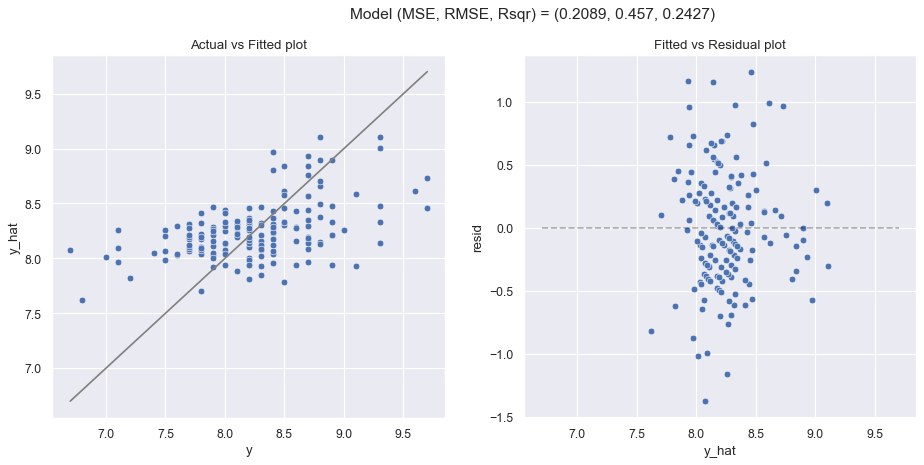

[ 5.08319383e+00  1.85154008e-03  1.39202908e-01 -1.02350529e-04
 -1.17185160e-02  6.88938210e-01]


In [434]:
# Tristans code but without character names

# Define headers to regress on
head = ['n_lines', 'n_directions', 'n_words', 'n_speak_char', 'n_scenes']

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]

# regress the regression 
test_model = LinearRegression()
test_model.fit(X_train_,y_train)

# use the regressed regression to predict
y_train_pred = test_model.predict(X_train_)
y_test_pred = test_model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

model_fit(test_model, X_train_, y_train, plot = True)
print(get_coefs(test_model))

In the first model, the points in the actual vs fitted plot are much closer to the fitted line than the second mode, suggesting it is indeed better. For both residual plots the points seem to be equally distributed about 0, suggesting linearity assumption is indeed reasonable. Some points are quite far away from the 0 line suggesting the model struggles to deal with outliers, however this is slightly better in first plot. Finally R^2 value of first plot is better as well as MSE and RMSE.

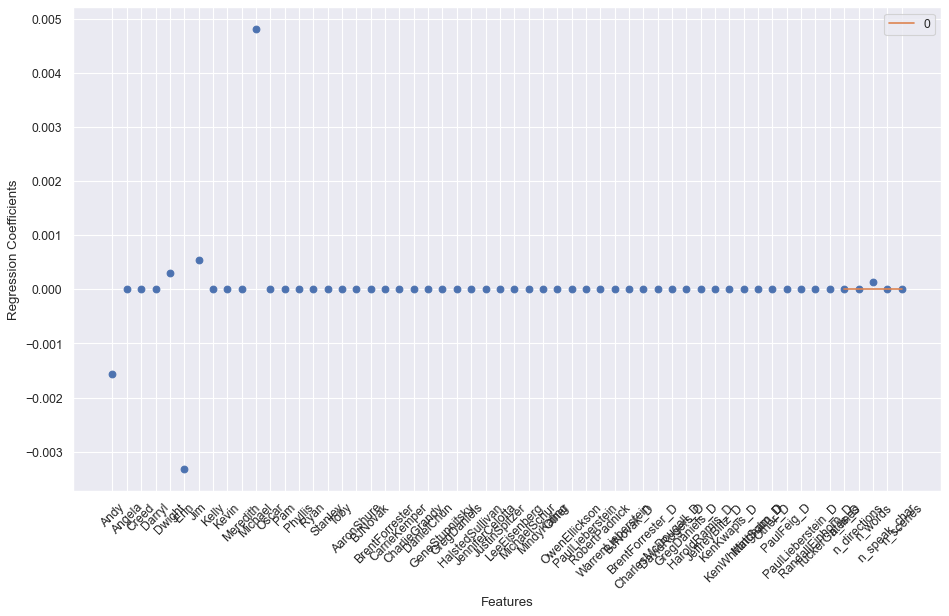

In [435]:
plt.plot(coeffs,'o')
plt.xticks(rotation=45)

plt.plot(head,[0]*len(head), label='0')

#plt.yscale('symlog')

plt.legend()
plt.ylabel('Regression Coefficients')
plt.xlabel('Features')
plt.show()


## better models, maybe

In [436]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Define headers to regress on
head0 = ['n_lines', 'n_directions', 'n_words', 'n_speak_char']
head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]


# List of models
models_list = [
    LinearRegression(), 
    Lasso(), 
    LassoLars(), 
    OrthogonalMatchingPursuit(), 
    BayesianRidge() , 
    ARDRegression(),
    TweedieRegressor(),
    DecisionTreeRegressor(), #overfitting
    KNeighborsRegressor()
]

for model in models_list:
    # regress the regression 
    print(model)
    model = make_pipeline(
        #PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
        #RFECV(LinearRegression(), step=1, cv=len(X_train_)-1),
        #LeaveOneOut(),
        StandardScaler(),
        model
        ).fit(X_train_, y_train)

    # use the regressed regression to predict
    y_train_pred = model.predict(X_train_)
    y_test_pred = model.predict(X_test_)

    # Rsquared
    print(r'Train $R^2$', r2_score(y_train, y_train_pred))
    print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
# print(model.named_steps['linearregression'].intercept_)
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_,columns=['Coefficients'])
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_, head, columns=['Coefficients'])
# coeffs


LinearRegression()
Train $R^2$ 0.5487542145243959
Test $R^2$ 0.13970669276416747
Lasso()
Train $R^2$ 0.0
Test $R^2$ -3.4172851283376104e-05
LassoLars()
Train $R^2$ 0.0
Test $R^2$ -3.4172851283376104e-05
OrthogonalMatchingPursuit()
Train $R^2$ 0.38887622700334457
Test $R^2$ 0.25427503594188894
BayesianRidge()
Train $R^2$ 0.485956576869052
Test $R^2$ 0.22649536765914802
ARDRegression()
Train $R^2$ 0.4912426776386658
Test $R^2$ 0.1926933154181687
TweedieRegressor()
Train $R^2$ 0.47666119701712506
Test $R^2$ 0.22749263987187218
DecisionTreeRegressor()
Train $R^2$ 1.0
Test $R^2$ -0.06389606442789808
KNeighborsRegressor()
Train $R^2$ 0.4536899830723987
Test $R^2$ 0.14108798055006866


In [437]:
from sklearn.tree import DecisionTreeRegressor

# Define headers to regress on
head0 = ['n_lines', 'n_directions', 'n_words', 'n_speak_char', 'n_scenes']
head = list(people.keys()) + head0

# get regressing cols
X_train_ = X_train[head]
X_test_ = X_test[head]


# regress the regression 
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
    RFECV(DecisionTreeRegressor(), step=1, cv=len(X_train_)-1),
    #LeaveOneOut(),
    DecisionTreeRegressor()
    ).fit(X_train_, y_train)

# use the regressed regression to predict
y_train_pred = model.predict(X_train_)
y_test_pred = model.predict(X_test_)

# Rsquared
print(r'Train $R^2$', r2_score(y_train, y_train_pred))
print(r'Test $R^2$', r2_score(y_test, y_test_pred))

# coefficients of regression
# print(model.named_steps['linearregression'].intercept_)
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_,columns=['Coefficients'])
# coeffs = pd.DataFrame(model.named_steps['linearregression'].coef_, head, columns=['Coefficients'])
# coeffs

KeyboardInterrupt: 

### Non - Linear Models 

NameError: name 'model' is not defined

## 4. Discussion and Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

- You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.

- This should be written with a target audience of a NBC Universal executive who is with the show and university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. 

- Your goal should be to convince this audience that your model is both accurate and useful.

- Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.

**Keep in mind that a negative result, i.e. a model that does not work well predictively, but that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explanations / justifications.**

## 5. References

[1] The Office lines 
AUTHOR: Abhinav Ralhan
URL: https://data.world/abhinavr8/the-office-scripts-dataset
DATE  CREATED: 12/05/2018
ACCESSED: 28/02/2023

stackexchange

chatGPT

Tristan Pang
